# Модуль 1. Введение в сбор данных

Федоров Георгий

### Наш рабочий проект: *обучение модели-ассистента для редактирования изображений ("умный фотошоп")*

> Идея работы модели: пользователь прикрепляет изображение и пишет инструкцию (н., "удали людей с заднего плана и поменяй мою кепку на соломенную шляпу"), модель же выдаёт отредактированное соответственным образом изображение
(что-то подобное недавно реализовали в Gemini и в GPT-4o, но из-за авторегрессионного подхода картинка сильно меняется -> это скорее перерисовка всего изображения, чем точечное редактирование нужных участков)

Один из хороших источников данных для такой задачи: сабреддит r/PhotoshopRequest, где пользователи выкладывают изображения и просьбы редактирования, а в комментариях им прикрепляют результаты.

In [120]:
import praw
import os
import random
from PIL import Image
import re
import json
import pandas as pd
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import polars as pl
from tqdm import tqdm
import seaborn as sns

from IPython.display import clear_output

## **[1]** Соберите данные из двух разных источников (открытый датасет + веб-скрейпинг или API).

### Стоит учитывать, что датасет, который вы сформируете на данном этапе пригодится вам для дальнейшего задания.

В первых домашках работа будет вестись только с табличными/текстовыми данными. Непосредственно картинки введём в домашке 4, про мультимодальность.

Поскольку реддит предоставляет только лучшие 1000 постов за указанный промежуток времени, парсить сабреддит целиком невозможно. Однако добрые люди раз в год выгружают весь реддит (!), распределяют его по сабреддитам и заливают на торрент. Поэтому, наши данные из двух источников будут такие:

1. **открытый датасет** - торрент-архив всего r/PhotshopRequest с самого начала по 2024 год включительно
2. **API** - будем использовать библиотеку **praw** для парсинга актуальных, свежих постов из сабреддита

`P.S.
да, это "открытый датасет" и "два разных источника" только с небольшой натяжкой, но мне кажется, что ради качества и эффективности работы можно проявлять небольшую гибкость, так что надеюсь, что такие источники подойдут :)` 

In [2]:
# Скачал .torrent-файл отсюда: https://academictorrents.com/details/1614740ac8c94505e4ecb9d88be8bed7b6afddd4
# Выбрал только PhotoshopRequest_submissions, загрузил, распаковал (датасет тяжелый, нужно подождать)

raw = pd.read_json('PhotoshopRequest_submissions', lines=True)
raw

,downs,link_flair_text,distinguished,media,url,link_flair_css_class,id,edited,num_reports,created_utc,...,retrieved_utc,top_awarded_type,url_overridden_by_dest,gallery_data,is_gallery,call_to_action,author_is_blocked,updated_on,previous_selftext,_meta
0,0.0,None,None,None,http://www.reddit.com/r/PhotoshopRequest/comme...,None,v9h62,0,NaN,1340082463,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.0,None,None,None,http://www.reddit.com/r/PhotoshopRequest/comme...,None,v9fi1,0,NaN,1340080357,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.0,None,None,None,http://www.reddit.com/r/PhotoshopRequest/comme...,None,x43s2,0,NaN,1343188886,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.0,None,None,None,http://www.reddit.com/r/PhotoshopRequest/comme...,None,10by6r,0,NaN,1348378155,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.0,None,None,None,http://www.reddit.com/r/PhotoshopRequest/comme...,None,10ev4t,0,NaN,1348521357,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
636939,0.0,Free :snoo:,None,None,https://i.redd.it/4r99hxvru9ae1.jpeg,free,1hqr3oq,0,0.0,1735689083,...,NaN,NaN,https://i.redd.it/4r99hxvru9ae1.jpeg,NaN,NaN,NaN,0.0,1.735689e+09,NaN,"{'removal_type': 'deleted', 'retrieved_2nd_on'..."
636940,0.0,Paid :redditgold:,None,None,https://www.reddit.com/gallery/1hqr3v5,paid,1hqr3v5,0,0.0,1735689100,...,NaN,NaN,https://www.reddit.com/gallery/1hqr3v5,"{'items': [{'id': 577726924, 'media_id': 'vdae...",1.0,NaN,0.0,1.735689e+09,NaN,"{'removal_type': 'deleted', 'retrieved_2nd_on'..."
636941,0.0,Paid :redditgold:,None,None,https://i.redd.it/beugcd1lv9ae1.jpeg,paid,1hqr6n8,0,0.0,1735689368,...,NaN,NaN,https://i.redd.it/beugcd1lv9ae1.jpeg,NaN,NaN,NaN,0.0,1.735689e+09,NaN,"{'removal_type': 'deleted', 'retrieved_2nd_on'..."
636942,0.0,Paid :redditgold:,None,None,https://i.redd.it/wk3lm6jsv9ae1.jpeg,paid,1hqr796,0,0.0,1735689425,...,NaN,NaN,https://i.redd.it/wk3lm6jsv9ae1.jpeg,NaN,NaN,NaN,0.0,1.735689e+09,NaN,{'retrieved_2nd_on': 1735819032}


In [6]:
# Перед переходом к API-способу и агрегации, слегка облегчим этот датасет
# сначала найдем все бессмысленные признаки
single_value_cols = []
dict_cols = []
for col in raw.columns:
    try:
        if raw[col].nunique() <= 1:
            single_value_cols.append(col)
    except TypeError:
        dict_cols.append(col)

In [7]:
single_value_cols

['downs',
 'distinguished',
 'num_reports',
 'banned_by',
 'subreddit',
 'likes',
 'clicked',
 'saved',
 'subreddit_id',
 'approved_by',
 'hidden',
 'from',
 'from_kind',
 'from_id',
 'quarantine',
 'suggested_sort',
 'brand_safe',
 'author_cakeday',
 'view_count',
 'approved_at_utc',
 'banned_at_utc',
 'can_mod_post',
 'parent_whitelist_status',
 'pinned',
 'subreddit_type',
 'mod_note',
 'mod_reason_by',
 'mod_reason_title',
 'category',
 'content_categories',
 'is_original_content',
 'media_only',
 'post_categories',
 'pwls',
 'removal_reason',
 'visited',
 'is_meta',
 'subreddit_name_prefixed',
 'author_patreon_flair',
 'discussion_type',
 'removed_by',
 'is_created_from_ads_ui',
 'top_awarded_type',
 'gallery_data',
 'is_gallery',
 'call_to_action',
 'author_is_blocked']

Это фичи, которые содержат либо `None`, либо какое-то одинаковое для всех значение (например, `0`).

Я просмотрел их все по порядку, и выделил только два полезных столбца:

In [3]:
# пост ли это от модератора (нам такие не нужны, удаляем)
raw['distinguished'].value_counts()

distinguished
moderator    35
Name: count, dtype: int64

In [4]:
# загрузил ли автор сразу несколько картинок (галерею) - мы работаем только с одной картинкой на вход, такие удаляем
raw['is_gallery'].value_counts()

is_gallery
1.0    88345
Name: count, dtype: int64

In [5]:
raw.drop(index=raw[raw['distinguished'] == 'moderator'].index, inplace=True)
raw.drop(index=raw[raw['is_gallery'] == 1.0].index, inplace=True)
len(raw)

548564

In [9]:
# теперь удаляем все мусорные фичи
raw.drop(columns=single_value_cols, inplace=True)
len(raw.columns)

83

При поиске неирнформативных признаков мы дополнительно отлавливали те, которые при вызове .nunique() дают TypeError - и складывали их в `dict_cols`. Это нехешируемые признаки (как правило, типа 'dict' или 'list'). Зачастую в них много мусорной мета-информации и прочих вещей, которые много весят и не нужны нам.

Рассмотрим их:

In [10]:
dict_cols

['media',
 'media_embed',
 'report_reasons',
 'secure_media',
 'secure_media_embed',
 'mod_reports',
 'user_reports',
 'preview',
 'crosspost_parent_list',
 'author_flair_richtext',
 'link_flair_richtext',
 'media_metadata',
 'previous_visits',
 'gildings',
 'all_awardings',
 'awarders',
 'treatment_tags',
 '_meta']

In [14]:
# пример непустого значения признака 'media'
raw[~raw['media'].isna()].sample(1)['media'].item()

{'oembed': {'provider_name': 'YouTube',
  'provider_url': 'http://www.youtube.com/',
  'title': 'Worst Sheep Rescue Ever',
  'thumbnail_url': 'http://i.ytimg.com/vi/m7SVrt5H-dA/hqdefault.jpg',
  'width': 600,
  'thumbnail_width': 480,
  'description': 'Subscribe! Worst Sheep Rescue Ever That moment when no one knows if everyone OK is kind of exciting. Sheep rescue New Zealand - Thoughtful how thoughtful of these people to rescue a sheep which had gotten stuck in some Worst Sheep Rescue EVER!!! Sheep Rescue attempt...',
  'url': 'http://www.youtube.com/watch?v=m7SVrt5H-dA',
  'type': 'video',
  'author_url': 'http://www.youtube.com/user/MOVIEAWARDS2013',
  'thumbnail_height': 360,
  'author_name': 'Claudia HD',
  'height': 450,
  'html': '&lt;iframe class="embedly-embed" src="//cdn.embedly.com/widgets/media.html?src=http%3A%2F%2Fwww.youtube.com%2Fembed%2Fm7SVrt5H-dA%3Ffeature%3Doembed&amp;url=https%3A%2F%2Fwww.youtube.com%2Fwatch%3Fv%3Dm7SVrt5H-dA&amp;image=http%3A%2F%2Fi.ytimg.com%2Fvi

Как видим, `media` содержит дамп метаданных видео, если автор поста прикрепил его.

Этих данных может быть очень много, и они совершенно нам не нужны.

Ссылку на картинку можно извлечь из более лёгких признаков, либо через `praw` по id поста. Так что для анализа данных нам нужны только id, title, selftext и немного полезных метаданных, вроде числа лайков, времени создания, и т.п.

Поэтому media, secure_media и прочие тяжелые признаки-словари нам в нашей задаче ни к чему.

In [42]:
raw.drop(columns=dict_cols, inplace=True)
len(raw.columns)

65

In [46]:
# сохраняем облегченный датасет
raw.reset_index(drop=True)
raw.to_csv('posts.csv')

In [50]:
del raw

Итак, мы сократили датасет с **2.12Гб** до **335.5Мб**, и перевели его в более удобный формат.

In [2]:
df = pd.read_csv('posts.csv').drop(columns='Unnamed: 0')
df

/var/folders/p_/mk0v57f13s7dcq7xcryjqlh0s_k83c/T/ipykernel_2564/3955965540.py:1: DtypeWarning: Columns (7,9,13,20,28,38,40,44,45,46,47,48,49,50,52,53,55,59,63,65) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/Users/21977981/Downloads/reddit/subreddits24/posts.csv').drop(columns='Unnamed: 0')


,link_flair_text,url,link_flair_css_class,id,edited,created_utc,name,title,author_flair_text,is_self,...,is_robot_indexable,total_awards_received,allow_live_comments,removed_by_category,author_premium,upvote_ratio,retrieved_utc,url_overridden_by_dest,updated_on,previous_selftext
0,NaN,http://www.reddit.com/r/PhotoshopRequest/comme...,NaN,v9h62,0,1340082463,t3_v9h62,Can someone edit this pic for me?,NaN,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,http://www.reddit.com/r/PhotoshopRequest/comme...,NaN,v9fi1,0,1340080357,t3_v9fi1,Can someone edit this picture for me?,NaN,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,http://www.reddit.com/r/PhotoshopRequest/comme...,NaN,x43s2,0,1343188886,t3_x43s2,Need Subreddit Mascot,NaN,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,http://www.reddit.com/r/PhotoshopRequest/comme...,NaN,10by6r,0,1348378155,NaN,Can you create a logo for my brand?,NaN,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,http://www.reddit.com/r/PhotoshopRequest/comme...,NaN,10ev4t,0,1348521357,NaN,I need to make a joke Birthday present for a f...,NaN,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
548559,Paid :redditgold:,https://i.redd.it/zqge6ajos9ae1.jpeg,paid,1hqqwb2,0,1735688379,t3_1hqqwb2,Is there anyway to sharpen this picture?,NaN,False,...,1.0,0.0,0.0,NaN,0.0,1.00,NaN,https://i.redd.it/zqge6ajos9ae1.jpeg,1.735688e+09,NaN
548560,Free :snoo:,https://i.redd.it/7sua3muxt9ae1.jpeg,free,1hqr0px,0,1735688802,t3_1hqr0px,just want a new lock screen,NaN,False,...,1.0,0.0,0.0,NaN,0.0,0.94,NaN,https://i.redd.it/7sua3muxt9ae1.jpeg,1.735689e+09,NaN
548561,Free :snoo:,https://i.redd.it/4r99hxvru9ae1.jpeg,free,1hqr3oq,0,1735689083,t3_1hqr3oq,Can someone make my fingers look less weird,NaN,False,...,1.0,0.0,0.0,NaN,0.0,1.00,NaN,https://i.redd.it/4r99hxvru9ae1.jpeg,1.735689e+09,NaN
548562,Paid :redditgold:,https://i.redd.it/beugcd1lv9ae1.jpeg,paid,1hqr6n8,0,1735689368,t3_1hqr6n8,Please remove individual in background - coffe...,NaN,False,...,1.0,0.0,0.0,NaN,0.0,1.00,NaN,https://i.redd.it/beugcd1lv9ae1.jpeg,1.735689e+09,NaN


In [51]:
# теперь посмотрим на остальные признаки, почистим от ненужных
df.columns

Index(['link_flair_text', 'url', 'link_flair_css_class', 'id', 'edited',
       'created_utc', 'name', 'title', 'author_flair_text', 'is_self',
       'author', 'permalink', 'author_flair_css_class', 'selftext', 'domain',
       'num_comments', 'thumbnail', 'ups', 'score', 'selftext_html', 'created',
       'over_18', 'gilded', 'retrieved_on', 'stickied', 'archived',
       'hide_score', 'post_hint', 'locked', 'contest_mode', 'spoiler',
       'thumbnail_height', 'can_gild', 'thumbnail_width', 'is_video',
       'is_crosspostable', 'num_crossposts', 'whitelist_status',
       'is_reddit_media_domain', 'crosspost_parent', 'no_follow',
       'send_replies', 'subreddit_subscribers',
       'author_flair_background_color', 'author_flair_template_id',
       'author_flair_text_color', 'author_flair_type', 'link_flair_text_color',
       'link_flair_type', 'rte_mode', 'wls', 'link_flair_background_color',
       'link_flair_template_id', 'author_created_utc', 'author_fullname',
       'is_r

Я посмотрел `value_counts` каждого и отсеял неинформативные/ненужные нам фичи

In [3]:
# удалим их
df.drop(columns=['edited', 'selftext_html', 'gilded', 'retrieved_on', 'stickied', 
 'thumbnail_height', 'thumbnail_width', 'author_flair_background_color',
 'author_flair_template_id', 'author_flair_text_color', 'author_flair_type',
 'link_flair_text_color', 'link_flair_type', 'rte_mode', 'wls', 'link_flair_background_color', 
 'link_flair_template_id', 'allow_live_comments', 'retrieved_utc', 'updated_on', 'previous_selftext'], inplace=True)
len(df.columns)

44

In [4]:
df.to_csv('posts_cleaner.csv')

In [2]:
df = pd.read_csv('posts_cleaner.csv').drop(columns='Unnamed: 0')
df

/var/folders/p_/mk0v57f13s7dcq7xcryjqlh0s_k83c/T/ipykernel_3980/459886781.py:1: DtypeWarning: Columns (6,8,12,31,33,38,41,44) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/Users/21977981/Downloads/reddit/subreddits24/posts_cleaner.csv').drop(columns='Unnamed: 0')


,link_flair_text,url,link_flair_css_class,id,created_utc,name,title,author_flair_text,is_self,author,...,send_replies,subreddit_subscribers,author_created_utc,author_fullname,is_robot_indexable,total_awards_received,removed_by_category,author_premium,upvote_ratio,url_overridden_by_dest
0,NaN,http://www.reddit.com/r/PhotoshopRequest/comme...,NaN,v9h62,1340082463,t3_v9h62,Can someone edit this pic for me?,NaN,True,UnknownReddit007,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,http://www.reddit.com/r/PhotoshopRequest/comme...,NaN,v9fi1,1340080357,t3_v9fi1,Can someone edit this picture for me?,NaN,True,[deleted],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,http://www.reddit.com/r/PhotoshopRequest/comme...,NaN,x43s2,1343188886,t3_x43s2,Need Subreddit Mascot,NaN,True,nismomonkey,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,http://www.reddit.com/r/PhotoshopRequest/comme...,NaN,10by6r,1348378155,NaN,Can you create a logo for my brand?,NaN,True,Aerimae,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,http://www.reddit.com/r/PhotoshopRequest/comme...,NaN,10ev4t,1348521357,NaN,I need to make a joke Birthday present for a f...,NaN,True,[deleted],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
548559,Paid :redditgold:,https://i.redd.it/zqge6ajos9ae1.jpeg,paid,1hqqwb2,1735688379,t3_1hqqwb2,Is there anyway to sharpen this picture?,NaN,False,holmesisonthecase,...,1.0,1325061.0,NaN,t2_9liljbau,1.0,0.0,NaN,0.0,1.00,https://i.redd.it/zqge6ajos9ae1.jpeg
548560,Free :snoo:,https://i.redd.it/7sua3muxt9ae1.jpeg,free,1hqr0px,1735688802,t3_1hqr0px,just want a new lock screen,NaN,False,nabi_sarang,...,1.0,1325069.0,NaN,t2_13stvrfuq4,1.0,0.0,NaN,0.0,0.94,https://i.redd.it/7sua3muxt9ae1.jpeg
548561,Free :snoo:,https://i.redd.it/4r99hxvru9ae1.jpeg,free,1hqr3oq,1735689083,t3_1hqr3oq,Can someone make my fingers look less weird,NaN,False,Sham-Shamm,...,1.0,1325070.0,NaN,t2_vj0dov7p,1.0,0.0,NaN,0.0,1.00,https://i.redd.it/4r99hxvru9ae1.jpeg
548562,Paid :redditgold:,https://i.redd.it/beugcd1lv9ae1.jpeg,paid,1hqr6n8,1735689368,t3_1hqr6n8,Please remove individual in background - coffe...,NaN,False,cantlearnemall,...,1.0,1325075.0,NaN,t2_r9h2g8wuj,1.0,0.0,NaN,0.0,1.00,https://i.redd.it/beugcd1lv9ae1.jpeg


### Парсинг реддита черед API

Актуальные посты можно получать через `praw` - python-библиотеку для парсинга реддита

Мы уже сделали `import praw` в начале (нужно установить библиотеку, есть в `pip` и `conda-forge`)

In [3]:
# устанавливаем подключение
reddit = praw.Reddit('bot1')

Такой способ инициализации парсера безопасен, т.к. отделяет креды от кода.
Нужные для инициализации креды кладутся в файл `praw.ini` следующим образом:

```
[bot1]
client_id=your_id
client_secret=your_secret
user_agent=your_agent_name
```
Подробнее про `praw.ini` в документации: https://praw.readthedocs.io/en/stable/getting_started/configuration/prawini.html#praw-ini

Для заполнения полей парсера выше нужно вместо заглушек проставить свои креды.

Получить их можно, зарегистрировав свой `app` в Reddit, подробнее можно почитать, например, тут: https://business.reddithelp.com/s/article/Create-a-Reddit-Application

Теперь давайте посмотрим, **что** и **как** нужно парсить через API.

Для этого посмотрим список оставленных нами фичей и сравниим его с полями произвольного спаршенного через API поста.

In [6]:
df.columns

Index(['link_flair_text', 'url', 'link_flair_css_class', 'id', 'created_utc',
       'name', 'title', 'author_flair_text', 'is_self', 'author', 'permalink',
       'author_flair_css_class', 'selftext', 'domain', 'num_comments',
       'thumbnail', 'ups', 'score', 'created', 'over_18', 'archived',
       'hide_score', 'post_hint', 'locked', 'contest_mode', 'spoiler',
       'can_gild', 'is_video', 'is_crosspostable', 'num_crossposts',
       'whitelist_status', 'is_reddit_media_domain', 'crosspost_parent',
       'no_follow', 'send_replies', 'subreddit_subscribers',
       'author_created_utc', 'author_fullname', 'is_robot_indexable',
       'total_awards_received', 'removed_by_category', 'author_premium',
       'upvote_ratio', 'url_overridden_by_dest'],
      dtype='object')

In [5]:
post = next(iter(reddit.subreddit('PhotoshopRequest').top(time_filter='week')))
post

Submission(id='1jvc07l')

In [7]:
post.__dict__.keys()

dict_keys(['comment_limit', 'comment_sort', '_reddit', 'approved_at_utc', 'subreddit', 'selftext', 'author_fullname', 'saved', 'mod_reason_title', 'gilded', 'clicked', 'title', 'link_flair_richtext', 'subreddit_name_prefixed', 'hidden', 'pwls', 'link_flair_css_class', 'downs', 'thumbnail_height', 'top_awarded_type', 'hide_score', 'name', 'quarantine', 'link_flair_text_color', 'upvote_ratio', 'author_flair_background_color', 'ups', 'total_awards_received', 'media_embed', 'thumbnail_width', 'author_flair_template_id', 'is_original_content', 'user_reports', 'secure_media', 'is_reddit_media_domain', 'is_meta', 'category', 'secure_media_embed', 'link_flair_text', 'can_mod_post', 'score', 'approved_by', 'is_created_from_ads_ui', 'author_premium', 'thumbnail', 'edited', 'author_flair_css_class', 'author_flair_richtext', 'gildings', 'post_hint', 'content_categories', 'is_self', 'subreddit_type', 'created', 'link_flair_type', 'wls', 'removed_by_category', 'banned_by', 'author_flair_type', 'doma

Как видим, многие из фичей напрямую лежат в посте аттрибутами, под теми же именами.

In [8]:
# проверим, все ли
for feature in df.columns:
    if feature not in post.__dict__.keys():
        print(f'feature [{feature}] is not in reddit post attributes')

feature [whitelist_status] is not in reddit post attributes
feature [crosspost_parent] is not in reddit post attributes
feature [author_created_utc] is not in reddit post attributes


Отлично, нет только фичей очень сомнительной степени нужности.

In [14]:
# создадим датасет, в который будем парсить
praw_df = pd.DataFrame(columns=df.columns)
praw_df

,link_flair_text,url,link_flair_css_class,id,created_utc,name,title,author_flair_text,is_self,author,...,send_replies,subreddit_subscribers,author_created_utc,author_fullname,is_robot_indexable,total_awards_received,removed_by_category,author_premium,upvote_ratio,url_overridden_by_dest


In [15]:
# попробуем положить в него распаршенный пример
row = dict()
for feature in df.columns:
    if feature not in post.__dict__.keys():
        row[feature] = np.nan
    else:
        row[feature] = post.__dict__[feature]
praw_df.loc[len(praw_df)] = row

In [16]:
praw_df

,link_flair_text,url,link_flair_css_class,id,created_utc,name,title,author_flair_text,is_self,author,...,send_replies,subreddit_subscribers,author_created_utc,author_fullname,is_robot_indexable,total_awards_received,removed_by_category,author_premium,upvote_ratio,url_overridden_by_dest
0,Solved ✅,https://i.redd.it/15xio2k9kute1.jpeg,,1jvc07l,1.744221e+09,t3_1jvc07l,Please put my girlfriend's idiot in a suit and...,None,False,ThruggNasty,...,True,1558010,NaN,t2_9s5fdnro,True,0,None,False,0.97,https://i.redd.it/15xio2k9kute1.jpeg


Отлично!

Теперь распарсим таким образом топ-1000 постов за месяц (больше 1000 реддит не хранит в топе)

In [64]:
praw_df = pd.DataFrame(columns=df.columns)
for post in tqdm(reddit.subreddit('PhotoshopRequest').top(time_filter='month', limit=None)):
    row = dict()
    for feature in df.columns:
        if feature not in post.__dict__.keys():
            row[feature] = np.nan
        else:
            row[feature] = post.__dict__[feature]
    praw_df.loc[len(praw_df)] = row

995it [00:28, 35.33it/s]


In [65]:
praw_df

,link_flair_text,url,link_flair_css_class,id,created_utc,name,title,author_flair_text,is_self,author,...,subreddit_subscribers,author_created_utc,author_fullname,is_robot_indexable,total_awards_received,removed_by_category,author_premium,upvote_ratio,url_overridden_by_dest,src
0,Solved ✅,https://i.redd.it/ubff9kjh4nse1.jpeg,,1jqltg2,1.743695e+09,t3_1jqltg2,"Please Remove Obama, He Accidentally Photobomb...",None,False,fruchtiiii,...,1558726,NaN,t2_6ip77sjs,True,0,None,0.0,0.90,https://i.redd.it/ubff9kjh4nse1.jpeg,NaN
1,Solved ✅,https://www.reddit.com/gallery/1ji3qeq,,1ji3qeq,1.742749e+09,t3_1ji3qeq,"It’s my dogs birthday today, can you please ad...",None,False,diamondpupper,...,1558726,NaN,t2_348qpuor,True,0,None,0.0,0.97,https://www.reddit.com/gallery/1ji3qeq,NaN
2,Solved ✅,https://www.reddit.com/gallery/1jhg6s8,,1jhg6s8,1.742671e+09,t3_1jhg6s8,My baby nephew has passed,None,False,AdMinimum3919,...,1558726,NaN,t2_7pq5ma1b,True,0,None,0.0,0.91,https://www.reddit.com/gallery/1jhg6s8,NaN
3,Solved ✅,https://i.redd.it/15xio2k9kute1.jpeg,,1jvc07l,1.744221e+09,t3_1jvc07l,Please put my girlfriend's idiot in a suit and...,None,False,ThruggNasty,...,1558726,NaN,t2_9s5fdnro,True,0,None,0.0,0.97,https://i.redd.it/15xio2k9kute1.jpeg,NaN
4,Paid :redditgold:,https://i.redd.it/xkxq2spagpqe1.jpeg,paid,1jj2f2n,1.742851e+09,t3_1jj2f2n,My wife passed away in January and I love this...,None,False,lifesaberk,...,1558726,NaN,t2_4kqro0qr,True,0,None,0.0,0.99,https://i.redd.it/xkxq2spagpqe1.jpeg,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
990,Free :snoo:,https://www.reddit.com/gallery/1jdqztw,free,1jdqztw,1.742254e+09,t3_1jdqztw,Friend was shot (he's ok),None,False,Made4tv__,...,1558729,NaN,t2_1bz2an3f,True,0,None,False,0.75,https://www.reddit.com/gallery/1jdqztw,NaN
991,Solved ✅,https://i.redd.it/v6ttme1p7bpe1.jpeg,,1jdmvbc,1.742243e+09,t3_1jdmvbc,I had lovely vacation in morocco last summer. ...,None,False,selibendorf,...,1558729,NaN,t2_4mauww7k,True,0,None,False,0.73,https://i.redd.it/v6ttme1p7bpe1.jpeg,NaN
992,Solved ✅,https://www.reddit.com/gallery/1jdk787,,1jdk787,1.742237e+09,t3_1jdk787,Give a dog a paw? Literally.,Requester :snoo:,False,Pretty_Appointment82,...,1558729,NaN,t2_c76db80w,True,0,None,False,0.84,https://www.reddit.com/gallery/1jdk787,NaN
993,Paid :redditgold:,https://i.redd.it/yyv22b48d9pe1.jpeg,None,1jddn2b,1.742221e+09,t3_1jddn2b,I’d there any way this photo can be made clear...,None,False,jy725,...,1558729,NaN,t2_u7nz8,True,0,None,False,1.00,https://i.redd.it/yyv22b48d9pe1.jpeg,NaN


Попробуем также спарсить топ постов за год и топ постов за неделю (будем пропускать те, что у нас уже есть)

In [66]:
for post in tqdm(reddit.subreddit('PhotoshopRequest').top(time_filter='year', limit=None)):
    if post.id not in list(df['id']) and post.id not in list(praw_df['id']):
        row = dict()
        for feature in df.columns:
            if feature not in post.__dict__.keys():
                row[feature] = np.nan
            else:
                row[feature] = post.__dict__[feature]
        praw_df.loc[len(praw_df)] = row

997it [01:07, 14.88it/s]


In [67]:
len(praw_df)

1275

In [68]:
for post in tqdm(reddit.subreddit('PhotoshopRequest').top(time_filter='week', limit=None)):
    if post.id not in list(df['id']) and post.id not in list(praw_df['id']):
        row = dict()
        for feature in df.columns:
            if feature not in post.__dict__.keys():
                row[feature] = np.nan
            else:
                row[feature] = post.__dict__[feature]
        praw_df.loc[len(praw_df)] = row

998it [01:07, 14.76it/s]


In [69]:
len(praw_df)

2031

По сравнению с архивом это немного, но мы собрали всё что смогли. Более того, парсить можно на постоянной основе. Можно автоматизировать процесс и запускать финальный скрипт парсинга, допустим, раз в неделю.

Также, поскольку фактический источник данных одинаков, то и распределения архивных и новых данных не должны глобально отличаться.

## **[2]** Проведите их агрегацию, создав единый датасет.

Поскольку мы заранее настроили парсинг в формате архивных данных, вся агрегация будет заключаться в простой конкатенации табличек

In [70]:
df['src'] = 'archive'
praw_df['src'] = 'api'

In [71]:
full_df = pd.concat([df, praw_df]).reset_index(drop=True)
full_df

,link_flair_text,url,link_flair_css_class,id,created_utc,name,title,author_flair_text,is_self,author,...,subreddit_subscribers,author_created_utc,author_fullname,is_robot_indexable,total_awards_received,removed_by_category,author_premium,upvote_ratio,url_overridden_by_dest,src
0,NaN,http://www.reddit.com/r/PhotoshopRequest/comme...,NaN,v9h62,1.340082e+09,t3_v9h62,Can someone edit this pic for me?,NaN,True,UnknownReddit007,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,archive
1,NaN,http://www.reddit.com/r/PhotoshopRequest/comme...,NaN,v9fi1,1.340080e+09,t3_v9fi1,Can someone edit this picture for me?,NaN,True,[deleted],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,archive
2,NaN,http://www.reddit.com/r/PhotoshopRequest/comme...,NaN,x43s2,1.343189e+09,t3_x43s2,Need Subreddit Mascot,NaN,True,nismomonkey,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,archive
3,NaN,http://www.reddit.com/r/PhotoshopRequest/comme...,NaN,10by6r,1.348378e+09,NaN,Can you create a logo for my brand?,NaN,True,Aerimae,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,archive
4,NaN,http://www.reddit.com/r/PhotoshopRequest/comme...,NaN,10ev4t,1.348521e+09,NaN,I need to make a joke Birthday present for a f...,NaN,True,[deleted],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,archive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
550590,Free :snoo:,https://www.reddit.com/gallery/1jynipv,free,1jynipv,1.744595e+09,t3_1jynipv,Car colors,None,False,Cheese1324,...,1558745.0,NaN,t2_59obl1uy,1.0,0.0,None,False,1.0,https://www.reddit.com/gallery/1jynipv,api
550591,Paid :redditgold:,https://i.redd.it/zhr3j8gl8pue1.jpeg,paid,1jymrja,1.744592e+09,t3_1jymrja,Help making some changes to a t-shirt design,None,False,Passessor,...,1558745.0,NaN,t2_16co3c,1.0,0.0,None,True,1.0,https://i.redd.it/zhr3j8gl8pue1.jpeg,api
550592,Paid :redditgold:,https://www.reddit.com/gallery/1jymegb,paid,1jymegb,1.744591e+09,t3_1jymegb,Can anyone complete and clean up this old and ...,None,False,throwrachacha100,...,1558745.0,NaN,t2_1abxeyx359,1.0,0.0,None,False,1.0,https://www.reddit.com/gallery/1jymegb,api
550593,Paid :redditgold:,https://i.redd.it/h4cnoiv53pue1.jpeg,None,1jym7l3,1.744591e+09,t3_1jym7l3,Can anyone edit out the guy on the right? Will...,None,False,spectralcanvas,...,1558745.0,NaN,t2_jlvlh33,1.0,0.0,None,False,1.0,https://i.redd.it/h4cnoiv53pue1.jpeg,api


In [72]:
full_df.to_csv('posts_cleaner_concated.csv')

## **[3]** Проведите разведывательный анализ данных (EDA).
## **[4]** Постройте базовые визуализации для основных признаков с учетом разметки данных.

Визуализации мне кажутся неотъемлемой частью EDA, поэтому объединяю эти два пункта

In [73]:
# сначала отыщем дубликаты
full_df[full_df.duplicated()]

,link_flair_text,url,link_flair_css_class,id,created_utc,name,title,author_flair_text,is_self,author,...,subreddit_subscribers,author_created_utc,author_fullname,is_robot_indexable,total_awards_received,removed_by_category,author_premium,upvote_ratio,url_overridden_by_dest,src


In [74]:
# проверим по уникальным полям
full_df[full_df.duplicated(subset=['id'],keep=False)].sort_values(by='id')

,link_flair_text,url,link_flair_css_class,id,created_utc,name,title,author_flair_text,is_self,author,...,subreddit_subscribers,author_created_utc,author_fullname,is_robot_indexable,total_awards_received,removed_by_category,author_premium,upvote_ratio,url_overridden_by_dest,src


In [77]:
# проверим по уникальным полям
full_df[~full_df['name'].isna() & full_df.duplicated(subset=['name'],keep=False)].sort_values(by='name')

,link_flair_text,url,link_flair_css_class,id,created_utc,name,title,author_flair_text,is_self,author,...,subreddit_subscribers,author_created_utc,author_fullname,is_robot_indexable,total_awards_received,removed_by_category,author_premium,upvote_ratio,url_overridden_by_dest,src


In [83]:
# посмотрим типы фичей
full_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550595 entries, 0 to 550594
Data columns (total 45 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   link_flair_text         383465 non-null  object 
 1   url                     536111 non-null  object 
 2   link_flair_css_class    331417 non-null  object 
 3   id                      550595 non-null  object 
 4   created_utc             550595 non-null  float64
 5   name                    396777 non-null  object 
 6   title                   550595 non-null  object 
 7   author_flair_text       5106 non-null    object 
 8   is_self                 550595 non-null  bool   
 9   author                  550585 non-null  object 
 10  permalink               550595 non-null  object 
 11  author_flair_css_class  820 non-null     object 
 12  selftext                245727 non-null  object 
 13  domain                  536085 non-null  object 
 14  num_comments        

#### **link_flair_text, link_flair_css_class**

In [91]:
flair1 = full_df['link_flair_text'].value_counts()
flair1

link_flair_text
Paid :redditgold:                105954
Serious :snoo:                    86865
Free :snoo:                       53965
SOLVED                            42932
Funny :snoo_joy:                  29550
Serious (Solved) :snoo:           18525
SOLVED                            12489
UNSOLVED                          11390
Solved ✅                          10292
Paid (Solved) :redditgold:         6708
Funny (Solved) :snoo_joy:          4464
  Abandoned ☠️                      231
Unsolved  :snoo_facepalm:            56
Solved :snoo_smile:                  12
Question :snoo_thoughtful:           11
Paid (Solved) :redditgold:            6
Paid                                  5
Mod Announcement :king:               2
:snoo_smile: Solved                   1
:snoo_thoughtful: Question            1
:snoo: Serious                        1
Mod Announcement :king:               1
Serious                               1
Paid (Solved) :snoo_smile:            1
Serious (Solved) :snoo_s

In [92]:
flair2 = full_df['link_flair_css_class'].value_counts()
flair2

link_flair_css_class
paid             95179
serious          87742
free             54557
solved           42864
funny            29723
unsolved         11390
solvedrequest     8800
                  1151
question            11
Name: count, dtype: int64

Оба признака про одно и то же: *тип поста*

В данном сабреддите: 
- можно попросить бесплатную услугу (free),
- можно предложить плату за лучшее решение (paid),
- выполненные задачи помечаются (solved),
- также раньше были тэги серьезности (serious, funny)

`link_flair_text` более грязный, там собрались все форматы типов поста за долгие годы.

Можно использовать эту фичу для удаления мусорных сэмплов (question, announcement), а на будущее оставить только `link_flair_css_class`

In [105]:
# выбираем мусорные категории
to_drop = flair1[flair1 <= 231].index
to_drop

Index(['  Abandoned ☠️', 'Unsolved  :snoo_facepalm:', 'Solved :snoo_smile:',
       'Question :snoo_thoughtful:', 'Paid (Solved) :redditgold:', 'Paid',
       'Mod Announcement :king: ', ':snoo_smile: Solved',
       ':snoo_thoughtful: Question', ':snoo: Serious',
       'Mod Announcement :king:', 'Serious', 'Paid (Solved) :snoo_smile:',
       'Serious (Solved) :snoo_smile:', ':snoo: Solved'],
      dtype='object', name='link_flair_text')

In [110]:
# удаляем мусор
full_df.drop(index=full_df[full_df['link_flair_text'].isin(to_drop)].index, inplace=True)

<Axes: xlabel='link_flair_css_class', ylabel='Count'>

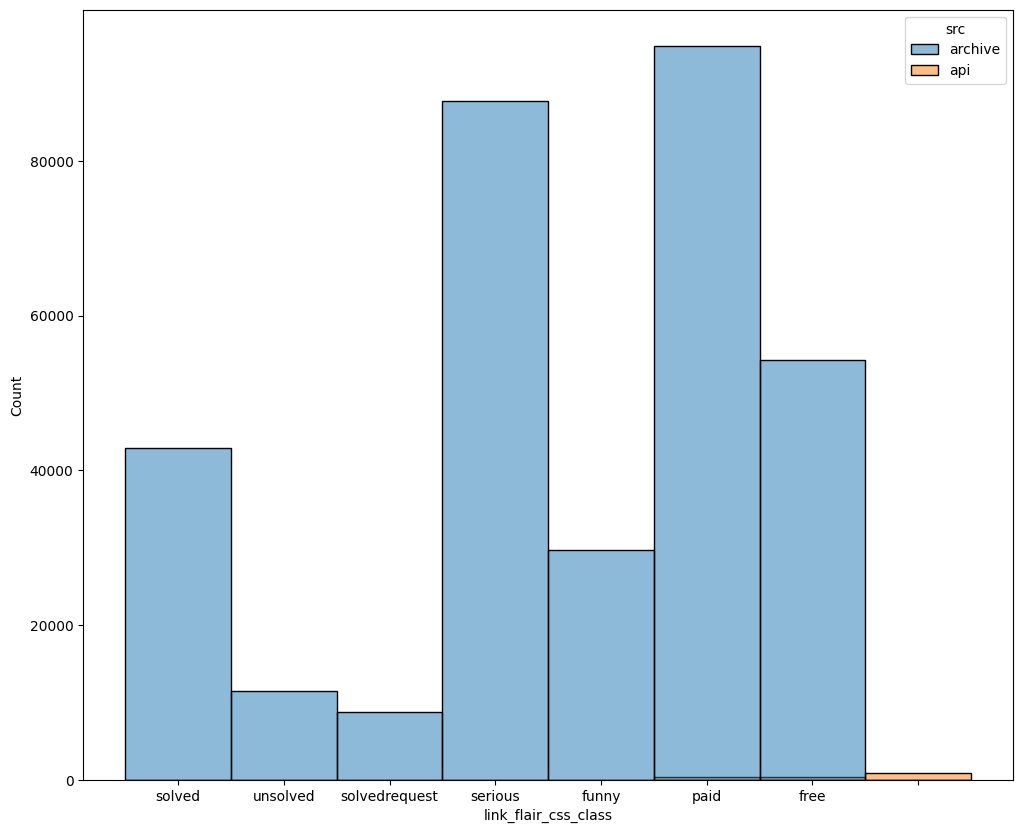

In [127]:
plt.figure(figsize=(12, 10))
sns.histplot(x=full_df['link_flair_css_class'], hue=full_df['src'])

Непонятная категория пустая, причём только у API-данных но заполнение пропусков - задача на PW2, так что решу её в следующей домашке

#### id, name, permalink
---
Это разные уникальные идентификаторы поста. Дубликатов нет.
Пропуски есть в `name` и `permalink`, но в `id` - ключевой, важнейший идентификатор - пропусков нет.

`name` и `permalink` скорее всего не нужны, но оставим на всякий.

#### 'author', 'author_fullname', 'author_premium', 'author_flair_text', 'author_flair_css_class'
---
Всякая информация об авторе поста
> здесь нигде нет ФИО, личных данных и прочей конфиденциальной информации об авторе - так что эти данные уже можно считать обезличенными

In [139]:
# как видим, много авторов удалили аккаунты за все эти годы
authors = full_df['author'].value_counts()
authors

author
[deleted]              140004
RealJohnGillman           244
Randomreddituser1o1       176
Physical-Egg-666          170
CoolClark                 132
                        ...  
burnburnaway                1
reekofsensation             1
DepressdTgirl2020           1
thattherebluedress          1
gunshot22                   1
Name: count, Length: 256716, dtype: int64

<Axes: xlabel='author'>

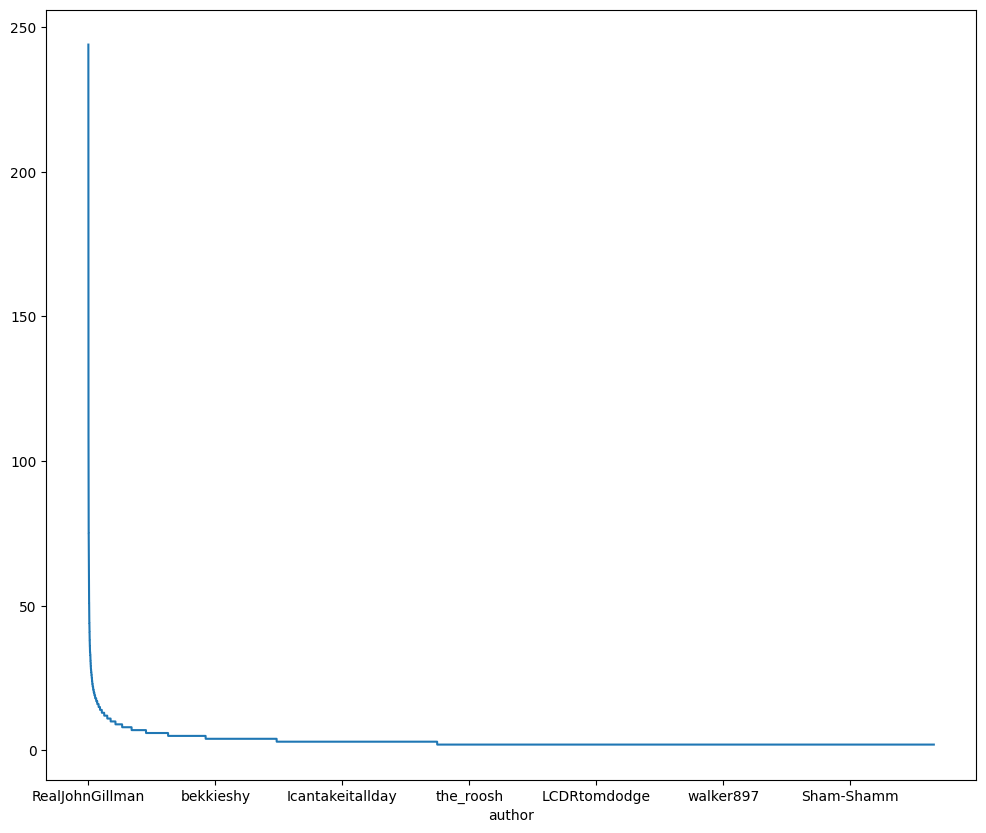

In [143]:
plt.figure(figsize=(12, 10))
authors[(authors > 1) & (authors < 140004)].plot()

Распределение вполне естественное.

Очень мало активных пользователей, очень много пользователей на 1-10 запросов.
Интересно посмотреть, зачем некоторые постят так много запросов

In [148]:
list(full_df[full_df['author'] == 'RealJohnGillman'].sample(10)['title'])

['Would someone possibly be able to un-blur / make clearer the top right-corner of this Joker image by any chance (or make it so that where the clearness ends does not look like a line across it at the triangle point and edges of the head and hair)? Thank you.',
 "[Random] Could someone isolate the right image here on its own if they're able? Thank you.",
 '[Specific] Could you please mirror-flip this image, turn the red a darker red, remove the number 25 and brown side from the right-hand-side, replacing the words POWELL &amp; HYDE Sts and UNITED RAILROADS with THE ETHICS EXPRESS (after having mirror-flipped it) in the font Ortem (linked below) Thank you.',
 'Could someone have this tattoo on its own mirroring both sides? Thank you.',
 '[Specific] Can someone replace the blurred Rick and Morty logo with the one below, reduced to the same size in the same place? Thank you.',
 'Could someone change this figure to resemble the below one? Thank you.',
 'Could someone change this sign to r

Видимо, кому-то по работе постоянно были нужны услуги фотошопа)

In [155]:
# id автора, столбец ненужный + много пропусков
full_df['author_fullname'].value_counts()

author_fullname
t2_iccpg6gd     177
t2_cptghui41    170
t2_b6fu6l4      137
t2_fqi2arp      132
t2_5kjq18q5     128
               ... 
t2_kw6b54ss       1
t2_d2vbg          1
t2_x1ca0          1
t2_lgmdwqz4       1
t2_oe4ug          1
Name: count, Length: 191834, dtype: int64

In [154]:
# есть ли у автора reddit-premium, может быть интересно, но много пропусков
full_df['author_premium'].value_counts()

author_premium
0.0    260058
1.0      3365
Name: count, dtype: int64

`author_flair` - это значки авторов, очень много пропусков и не особо нужны

In [165]:
full_df['author_flair_text'].value_counts()

author_flair_text
Requester :snoo:            3449
Wizard :wand:                734
+0                           289
+1                           173
Score (comment anywhere)      88
Wizard :baguette:             78
+2                            60
+3                            40
+4                            33
+9                            24
+5                            22
Wizard                        18
+7                            15
Moderator                     14
+6                             9
+8                             8
+16                            5
+54                            4
Trusted Wizard :wiz:           4
+10                            3
+11                            3
+13                            3
+42                            2
+29                            2
+60                            2
+41                            2
Wizard :wand::wand:            2
+23                            2
+43                            2
+37                      

In [166]:
full_df['author_flair_css_class'].value_counts()

author_flair_css_class
score-t1    522
score-t2    151
reset        88
score-t3     25
score-t4     20
mod          10
flair2        4
Name: count, dtype: int64

In [168]:
# но благодаря им можно удалить посты модераторов
full_df.drop(
    index=full_df[full_df['author_flair_text'] == 'Moderator'].index, inplace=True
)
full_df.drop(
    index=full_df[full_df['author_flair_css_class'] == 'mod'].index, inplace=True
)
full_df.reset_index(inplace=True, drop=True)

#### временнЫе аттрибуты поста
---

<Axes: >

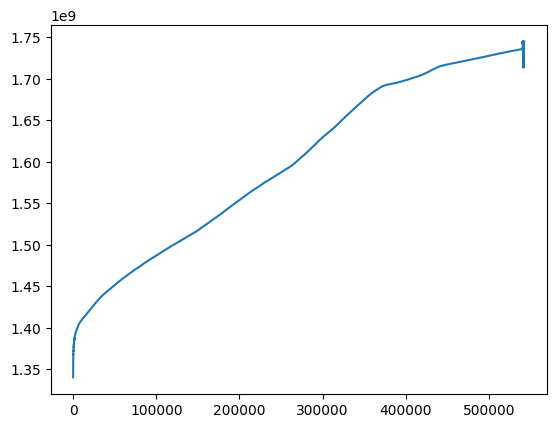

In [193]:
# UTC-время создания поста
full_df['created_utc'].plot()

(мешанина в конце - это API-датасет, я его не отсортировал по дате создания постов)

Видно, что пару лет назад интенсивность постинга возросла в разы.

Наверное, это связанно с появлением inpaint-нейросетей -> люди быстрее стали получать запрашиваемые фотошопы -> стало больше смысла постить новые запросы.

<Axes: >

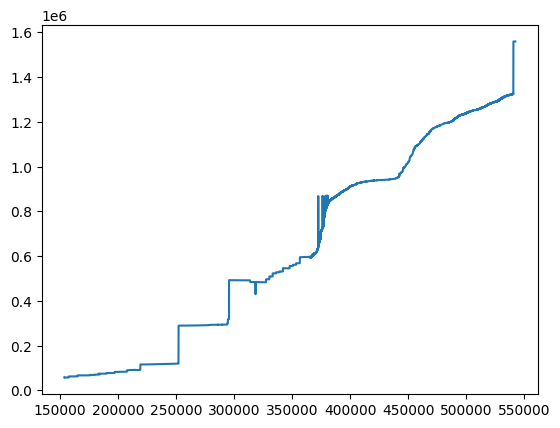

In [194]:
# число подписчиков в момент создания поста
full_df['subreddit_subscribers'].plot()

Фича просто интересная, никакой ценности не представляет

#### тип поста / контента поста
---

In [177]:
# domain - домен, где лежит прикреплённый к посту материал (н., картинка)
# может быть полезен в будущем, для извлечения изображений
full_df['domain'].value_counts()

domain
i.redd.it                       350171
self.PhotoshopRequest            80743
imgur.com                        51007
i.imgur.com                      24148
i.reddituploads.com               6883
                                 ...  
public.lightpic.info                 1
scontent-mrs1-1.xx.fbcdn.net         1
natureimage.xyz                      1
scarecrowboat.com                    1
poderpal.blogspot.com                1
Name: count, Length: 5012, dtype: int64

Видно, что почти все изображения распределены между двумя доменами:
- `reddit` - современный вариант, картинка лежит на сервере reddit
- `imgur` - старый вариант, видимо раньше нельзя было прикреплять фото

In [208]:
# ещё один признак по этому вопросу
full_df['is_reddit_media_domain'].value_counts()

is_reddit_media_domain
1.0    334604
0.0     79110
Name: count, dtype: int64

In [184]:
full_df['thumbnail'].value_counts().head(6)

thumbnail
default                                                                            213098
self                                                                                39531
nsfw                                                                                 3762
spoiler                                                                               949
http://b.thumbs.redditmedia.com/jL8FQOaugDww6y_wGfgtUM-FLopLI590facpMQxQfeg.jpg        25
http://a.thumbs.redditmedia.com/fAgJzE-U-jlgvXfbRRNEE-YDOauOIyUw0KgRNnq7b14.jpg        18
Name: count, dtype: int64

In [185]:
# эта фича очень полезна для удаления потенциального NSFW
full_df.drop(
    index=full_df[full_df['thumbnail'].isin(['nsfw', 'spoiler'])].index, inplace=True
)
full_df.reset_index(inplace=True, drop=True)

In [188]:
# для этих же целей есть пара других фичей
full_df.drop(
    index=full_df[full_df['over_18'] == True].index, inplace=True
)
full_df.drop(
    index=full_df[full_df['spoiler'] == 1.0].index, inplace=True
)
full_df.reset_index(inplace=True, drop=True)

In [210]:
# и ещё одна
full_df.drop(
    index=full_df[full_df['whitelist_status'] == 'promo_adult_nsfw'].index, inplace=True
)
full_df.reset_index(inplace=True, drop=True)

In [222]:
# и ещё одна
full_df.drop(
    index=full_df[full_df['removed_by_category'] == 'content_takedown'].index, inplace=True
)
full_df.reset_index(inplace=True, drop=True)

In [198]:
# эта фича очень полезна для выявления типа поста
full_df['post_hint'].value_counts()

post_hint
image           258688
link             29007
self             14508
rich:video         208
hosted:video       119
video               10
Name: count, dtype: int64

In [200]:
# удалим все посты типа "видео", мы целимся только в редактирование картинок
full_df.drop(
    index=full_df[full_df['post_hint'].isin(
        ['rich:video', 'hosted:video', 'video']
    )].index, inplace=True
)
full_df.reset_index(inplace=True, drop=True)

In [203]:
# аналогичная фича
full_df.drop(
    index=full_df[full_df['is_video'] == 1.0].index, inplace=True
)
full_df.reset_index(inplace=True, drop=True)

In [231]:
# url - как правило, ссылка на прикрепленное изображение
full_df['url'].value_counts().head(10)
# легко отсеять невалидные изображения в будущем

url
https://i.redd.it/m3b7j7lofa4c1                                                                 20
http://google.com                                                                               11
http://i.imgur.com/j2JauW1.jpg                                                                   9
http://2.bp.blogspot.com/-B7GstsePrgo/UPldSxF1Z_I/AAAAAAAAEZY/TXlGlvEciYo/s1600/2408_001.jpg     9
https://ibb.co/ZBY2vVs                                                                           8
/r/severnpixels/comments/1gj9q57/creative_photo_editing_competition/                             8
https://i.redd.it/s70zevig01h81.jpg                                                              8
http://imgur.com/iunQmEq                                                                         7
http://imgur.com/a/ObWyK                                                                         7
https://www.reddit.com/r/PhotoshopRequest/submit                                                 7
Name: 

#### численные характеристики поста
---
это довольно важные метрики качества/популярности поста

<Axes: ylabel='num_comments'>

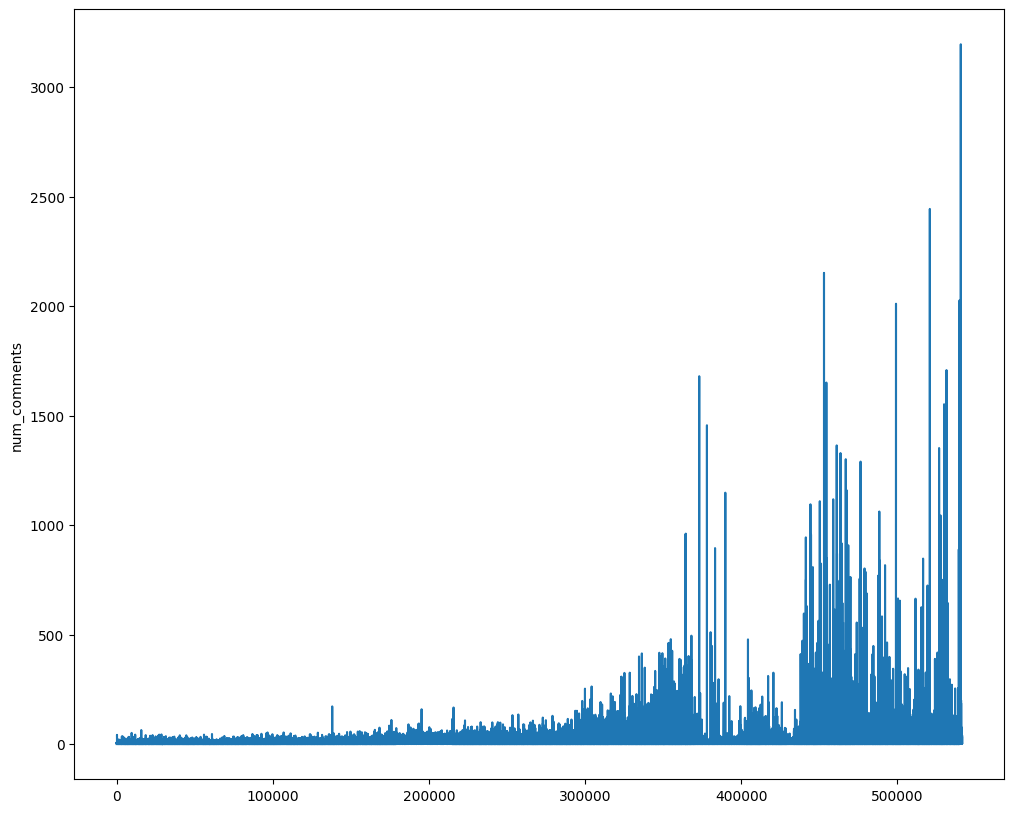

In [223]:
# число комментариев
plt.figure(figsize=(12, 10))
sns.lineplot(full_df['num_comments'])

Опять видно, что пару лет назад активность сильно возрасла

<Axes: ylabel='ups'>

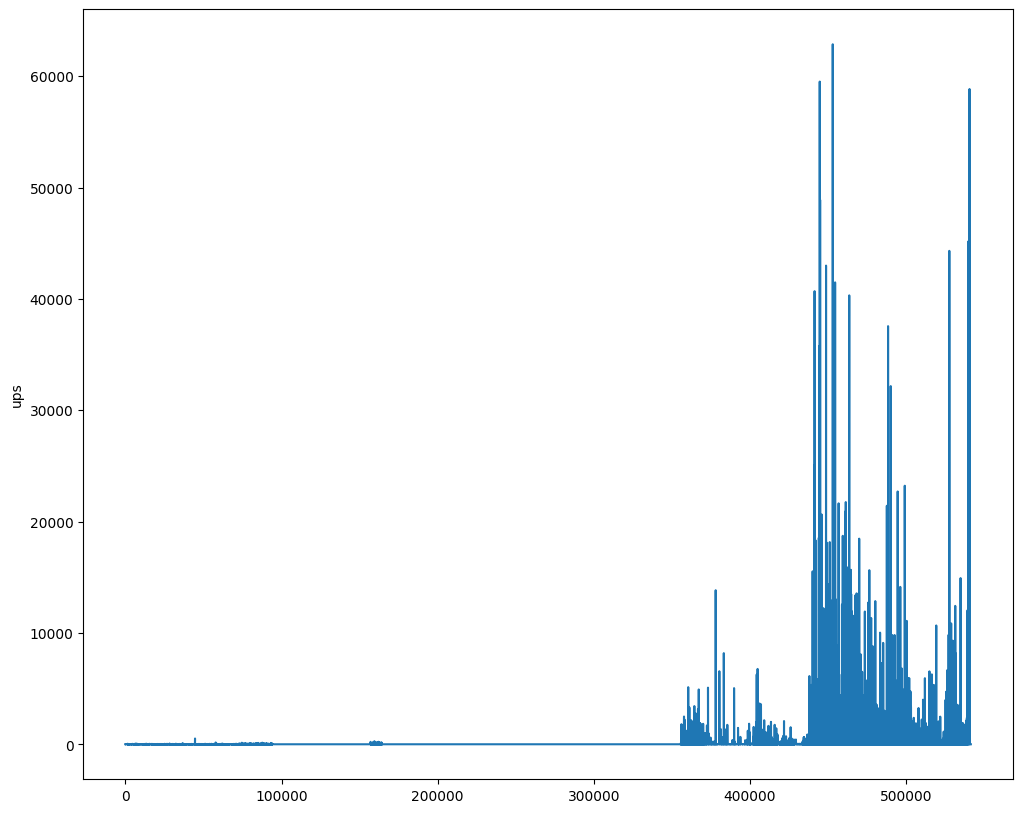

In [226]:
# число апвоутов
plt.figure(figsize=(12, 10))
sns.lineplot(full_df['ups'])

<Axes: ylabel='score'>

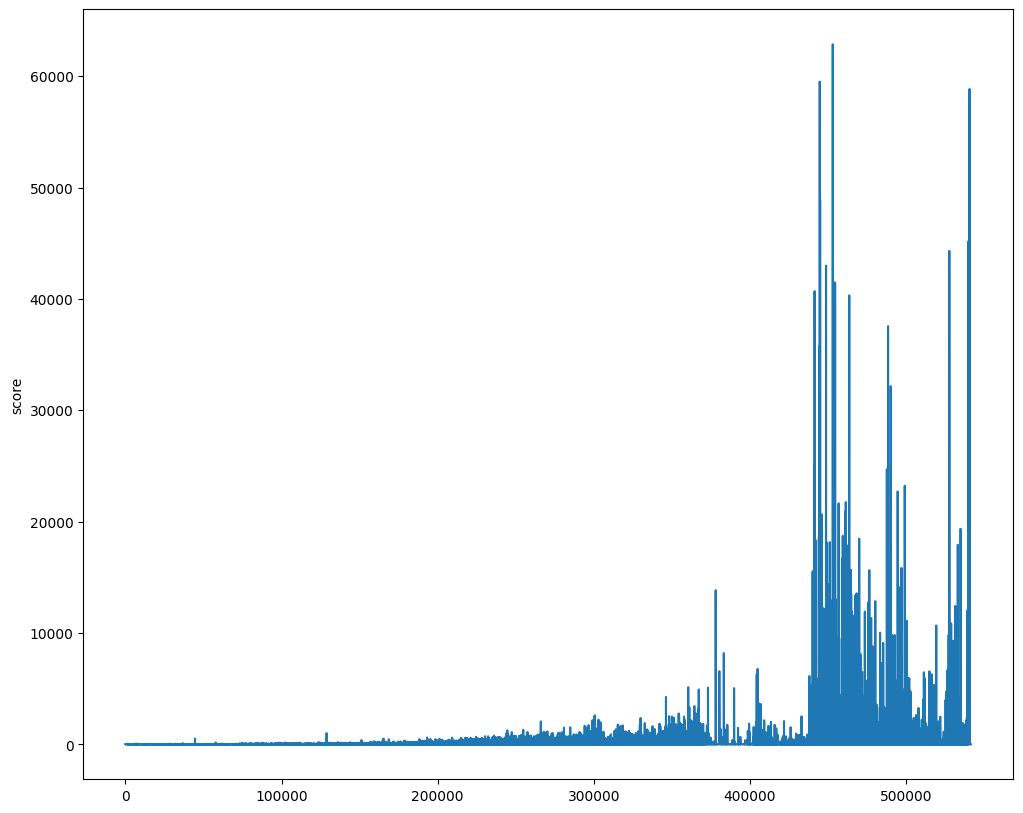

In [227]:
# скор поста
plt.figure(figsize=(12, 10))
sns.lineplot(full_df['score'])

Снова та же картина: раньше паблик был очень нишевым, а пару лет назад начался огромный всплеск активности.

<Axes: xlabel='upvote_ratio', ylabel='count'>

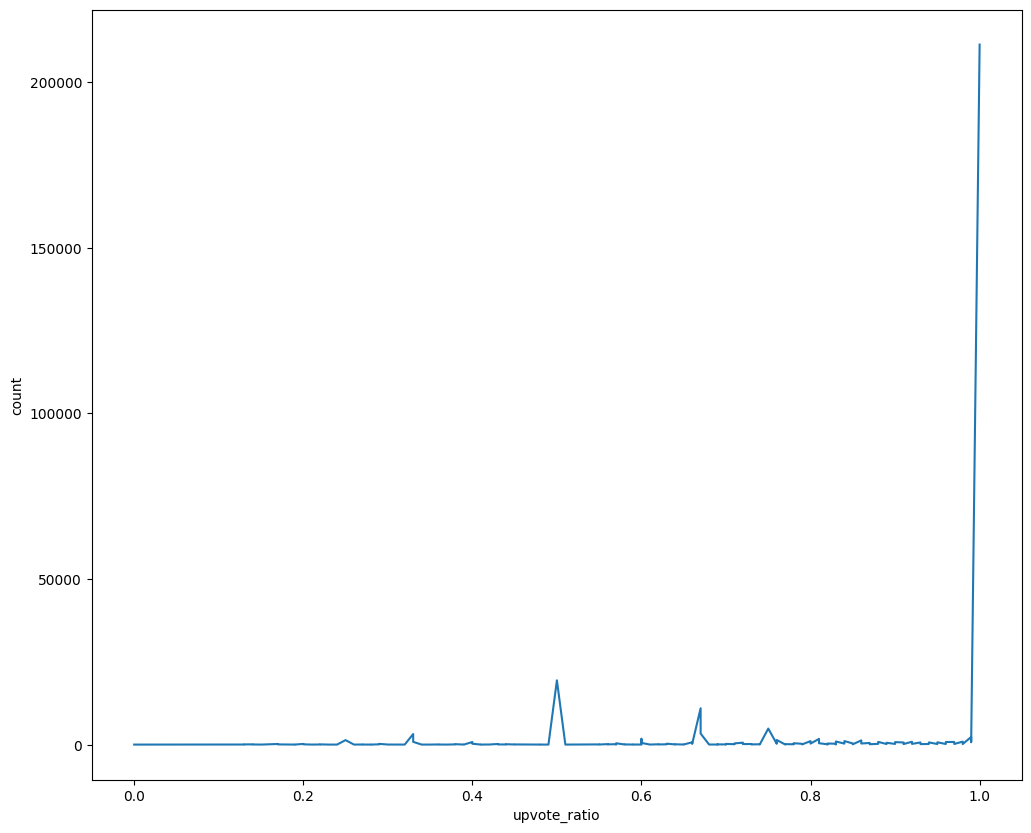

In [230]:
# соотношение апвоутов к даунвоутам
plt.figure(figsize=(12, 10))
sns.lineplot(full_df['upvote_ratio'].value_counts())

Большинство постов тут одинаковы (наверное, 1 апвоут 0 даунвоутов), но видны "вспышки" других типов постов.

Для популярных постов характерно иметь некоторую долю даунвоутов, но если апвоутов мало, и соотношение ближе к 0.5, то это веская причина удалить пост.

<Axes: ylabel='total_awards_received'>

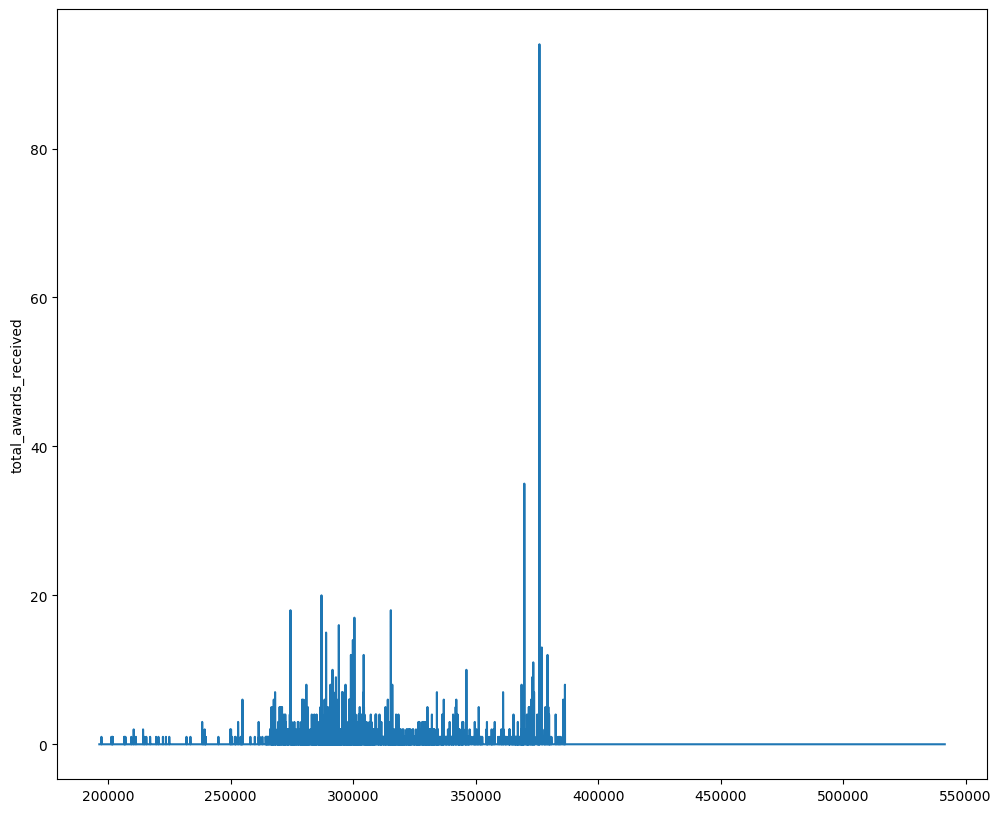

In [228]:
# число наград
plt.figure(figsize=(12, 10))
sns.lineplot(full_df['total_awards_received'])

Интересно, похоже эта метрика уже давно не считается?

#### основное содержимое поста
---
то, ради чего мы и парсим датасет: тексты запросов
Они могут быть в `title`, могут быть в `selftext`, а могу - и там, и там.

В будущем хорошим решением будет сконкатенировать эти две фичи в одну.

In [233]:
full_df['title'].value_counts().head(10)

title
[deleted by user]            7253
[image processing failed]     918
Help                          217
Request                       190
Photoshop request             187
Please help                   146
[Specific]                    107
Photoshop Request              98
Help!                          76
Please help!                   67
Name: count, dtype: int64

In [234]:
full_df['selftext'].value_counts().head(10)

selftext
[deleted]             112298
[removed]              41780
                         385
Thank you!               119
\n                        80
Thank you!                68
Thanks!                   68
Thanks in advance!        37
Thank you                 37
Thanks in advance         32
Name: count, dtype: int64

Интересно увидеть самые распространённые формулировки. Также, комбинация [пустой заголовок] + [пустое тело] - это кандидаты на удаление. Но это уже в следующей домашке...

### Взаимосвязи

In [237]:
# сначала, удалим все использованные (и теперь ненужные) фичи, 
# а также изначально ненужные фичи

full_df.drop(columns=[
    'can_gild', 'crosspost_parent', 'is_crosspostable', 'is_self', 
    'num_crossposts', 'no_follow', 'send_replies', 'is_robot_indexable', 
    'url_overridden_by_dest', 'name', 'permalink', 'author_fullname', 
    'author_premium', 'author_flair_text', 'author_flair_css_class', 
    'created', 'spoiler', 'thumbnail', 'spoiler', 'over_18', 
    'author_created_utc', 'subreddit_subscribers', 'archived', 
    'hide_score', 'post_hint', 'contest_mode', 'locked', 
    'whitelist_status', 'removed_by_category', 'is_video'
], inplace=True)

In [241]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541480 entries, 0 to 541479
Data columns (total 16 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   link_flair_text         376389 non-null  object 
 1   url                     527514 non-null  object 
 2   link_flair_css_class    325229 non-null  object 
 3   id                      541480 non-null  object 
 4   created_utc             541480 non-null  float64
 5   title                   541480 non-null  object 
 6   author                  541470 non-null  object 
 7   selftext                241265 non-null  object 
 8   domain                  527489 non-null  object 
 9   num_comments            541480 non-null  int64  
 10  ups                     287251 non-null  float64
 11  score                   541480 non-null  int64  
 12  is_reddit_media_domain  413327 non-null  float64
 13  total_awards_received   345125 non-null  float64
 14  upvote_ratio        

<Axes: >

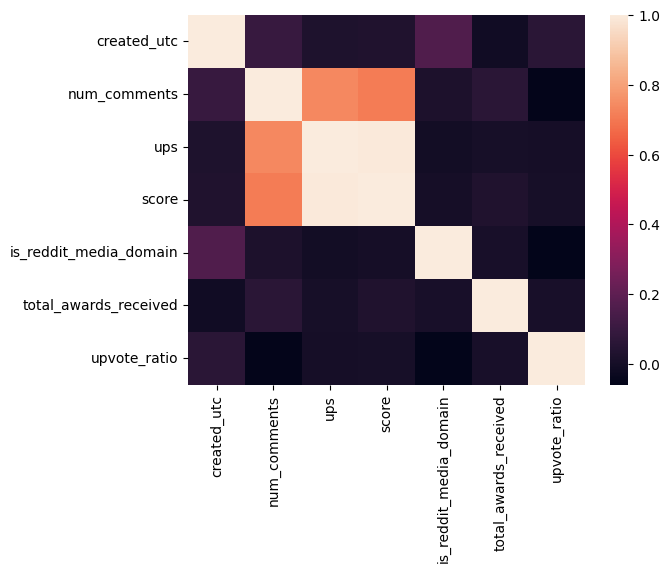

In [250]:
sns.heatmap(full_df.select_dtypes(['float64', 'int64']).corr())

- Как и ожидалось, почти полная корреляция между `ups` и `score`, один из них можно удалить.
- Также сильная корреляция между `num_comments` и `score`
- интересно, как чуть виднеется связь `created_utc` и `is_reddit_media_domain`: раньше доменом медиа был не реддит, сейчас - реддит.

In [251]:
full_df.to_csv('posts_cleaner_2.csv')

## [5] Опишите возможные применения этих данных в контексте машинного обучения.

1. Конкретно в нашей задаче нужны мультимодальные данные (триплеты [ориг. картинка] - [текстовый запрос] - [отредактированный результат]). Но мультимодальность у нас в четвертой домашке, это я настрою там.
2. Также сами тексты запросов нам очень важны. Во-первых, это максимально естественные примеры того, какие запросы будут у пользователей к модели-редактору. Во-вторых, из запросов можно извлеч типы задач и сформировать их распределение. Это важно, чтобы понять, в каких пропорциях учить модель задачам.
3. Также можно связать тексты с численными метриками постов. Например, можно обучать/алайнить какую-либо модель на синтез текстовых описаний, оценивая их качество фичами типа числа апвоутов, числа комментариев, скора.
4. Если отдельно парсить все комментарии к постам, можно использовать это для дообучения моделей на более естественную ассистентность в вопросе редактирования (по крайней мере, как обычно отвечают на те или иные запросы, особенно на юмор).